# 1. Importation de bibliothèque

(7351, 128)
(7351, 1)
[1.]
8


Calcul des features: 100%|██████████| 2298/2298 [00:06<00:00, 345.87it/s]


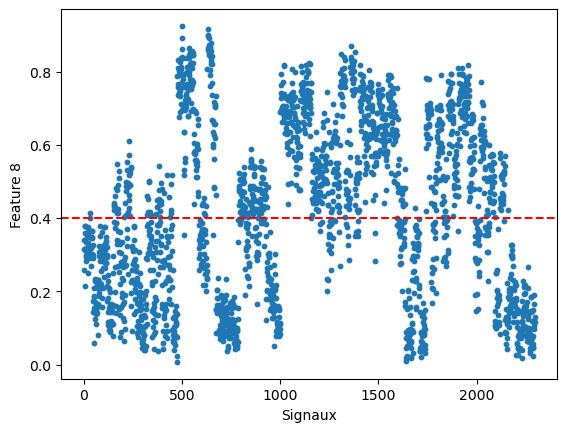

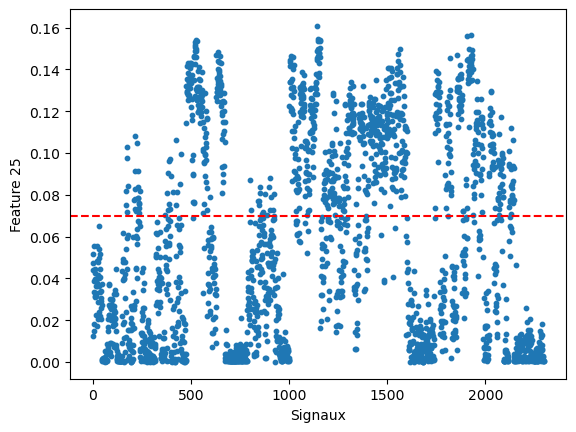

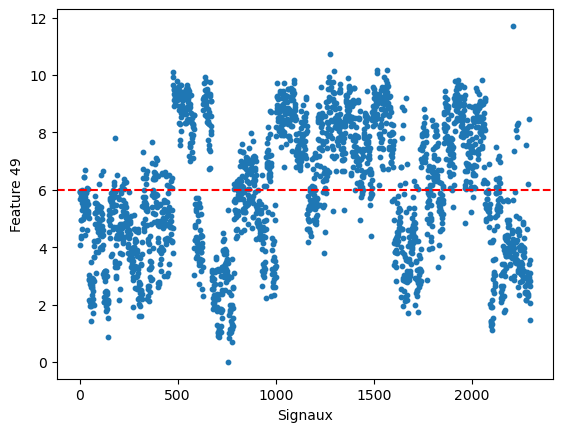

1083
1215
1368
930
1151
1147
Nombre et pourcentage d'éléments en commun entre les listes a et c :  1072 soit 99.0 %
Nombre et pourcentage d'éléments en commun entre les listes a et d :  11 soit 1.0 %
Nombre et pourcentage d'éléments en commun entre les listes b et c :  296 soit 24.4 %
Nombre et pourcentage d'éléments en commun entre les listes b et d :  919 soit 75.6 %
Nombre et pourcentage d'éléments en commun entre les listes c et e :  1056 soit 77.2 %
Nombre et pourcentage d'éléments en commun entre les listes c et f :  312 soit 22.8 %
Nombre et pourcentage d'éléments en commun entre les listes d et e :  95 soit 10.2 %
Nombre et pourcentage d'éléments en commun entre les listes d et f :  835 soit 89.8 %
Nombre et pourcentage d'éléments en commun entre les listes a et e :  922 soit 85.1 %
Nombre et pourcentage d'éléments en commun entre les listes a et f :  161 soit 14.9 %
Nombre et pourcentage d'éléments en commun entre les listes b et e :  229 soit 18.8 %
Nombre et pourcentage d'él

In [37]:
# Load this to check if all packages are installed
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
from scipy import stats
from scipy.fft import fft, ifft
from scipy.signal import find_peaks, butter, filtfilt
from statsmodels.tsa.ar_model import AutoReg
from sporco.admm import bpdn
from statsmodels.regression.linear_model import yule_walker
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
import time
import ruptures as rpt
from tqdm import tqdm
from loadmydata.load_uea_ucr import load_uea_ucr_data





#Constante
Fe = 50





#On importe les données 
with open('total_acc_z_train.txt', 'r') as file:
    content = file.readlines()
Datas = []

for line in content[:-1]: #parcourir le fichier
    first_line = line.strip()  # Enlève les espaces et les sauts de ligne
    values = [float(x) for x in first_line.split()]  # Convertit chaque valeur en float
    values_array = np.array(values)  # Convertir en tableau NumPy
    Datas.append(values_array)

Datas = np.array(Datas)
print (np.shape(Datas))

# On importe maintenant les label des données de manière à sélectionner nos deux classes d'étude parmi les 6 classes existantes.
with open('y_train.txt', 'r') as file:
    content = file.readlines()
DatasY = []
# Display the first 10 lines to understand the structure
for line in content[:-1]:  # Adjust the number of lines as needed
    first_line = line.strip()  # Enlève les espaces et les sauts de ligne
    values = [float(x) for x in first_line.split()]  # Convertit chaque valeur en float
    values_array = np.array(values)  # Convertir en tableau NumPy
    DatasY.append(values_array)

DatasY = np.array(DatasY)
print (np.shape(DatasY))
print (DatasY[100])

# Sélectionner les signaux où DatasY est dans [1, 2] c'est à dire les signaux où la personne est mobile
indices_mobiles = np.isin(DatasY, [1, 2]).flatten() # Flatten the boolean array to match the dimension of Datas
Datas_mobiles = Datas[indices_mobiles]# contient notre dataset




## Nous venons dans cette partie filtrer le bruit haute fréquence des données et la trend. 
class Signal:
    def __init__(self, data):
        """
        Initialise un objet Signal.

        :param data: Les données du signal (tableau numpy ou liste).
        :param sampling_rate: Fréquence d'échantillonnage (en Hz).
        """
        self.data = np.array(data)
        self.Fsampling = Fe
        self.sampling_rate = 1/Fe
        self.duration = 2.56
        self.time = np.linspace(0, self.duration, len(data))  # Axe temporel

    def plot(self, title="Signal", data = True , data_filtered = False, data_trend = False, data_filtered_detrend = False ):# fonction qui permet d'afficher les données à chaque étapes du traitement
        """
        Affiche le signal dans le domaine temporel.
        """
        plt.figure(figsize=(10, 4))
        if data :
          plt.plot(self.time, self.data, label = "signal d'origine")
        if data_filtered :
          plt.plot(self.time, self.filtered_data, label = "signal filtered")
        if data_trend :
          plt.plot(self.time, self.trend, label = "signal trend")
        if data_filtered_detrend :
          plt.plot(self.time, self.detrend_filtered_data, label ="signal filtered without trend")
        plt.title(title)
        plt.legend()
        plt.xlabel('Temps (s)')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.show()

        


    def filter_signal(self, cutoff, order=5, filter_type='low'):
        """
        Filtre le signal à l'aide d'un filtre passe-bas, passe-haut, ou passe-bande.

        :param cutoff: Fréquence de coupure (Hz).
        :param order: Ordre du filtre (plus élevé signifie un filtre plus "sharp").
        :param filter_type: Type de filtre ('low', 'high', 'band').
        :return: Le signal filtré.
        """
        nyquist = 0.5 * self.sampling_rate
        if filter_type == 'low':
            normal_cutoff = cutoff * nyquist
            b, a = butter(order, normal_cutoff, btype='low', analog=False)
        elif filter_type == 'high':
            normal_cutoff = cutoff * nyquist
            b, a = butter(order, normal_cutoff, btype='high', analog=False)
        elif filter_type == 'band':
            low, high = cutoff
            normal_cutoff = [low * nyquist, high * nyquist]
            b, a = butter(order, normal_cutoff, btype='band')
        else:
            raise ValueError("Type de filtre non supporté. Choisissez 'low', 'high' ou 'band'.")

        self.filtered_data = filtfilt(b, a, self.data)
        return self.filtered_data

    def trending(self):
        # Regression on polynomial functions
        N = len(self.data)
        t = np.linspace(0, self.duration, N)
        D=np.zeros((N,3))
        D[:,0]=np.ones(N)
        D[:,1]=t
        D[:,2]=np.power(t,2)


        alpha=np.dot(np.linalg.inv(np.dot(np.transpose(D),D)),np.dot(np.transpose(D),self.filtered_data)) #Regression parameters
        self.trend =np.dot(D,alpha); #Reconstruction
        self.detrend_filtered_data = self.filtered_data - self.trend; #Detrended signal
        return self.detrend_filtered_data
    def apply_fft(self, data = True , data_filtered = False, data_trend = False, data_filtered_detrend = False ):
        """
        Applique la transformation de Fourier rapide (FFT) au signal.

        :return: Tuple (fréquence, magnitude)
        """
        if data:
          N = len(self.data)
          T = 1/self.Fsampling
          yf = fft(self.data)
          xf = np.fft.fftfreq(N, T)[:N//2]
          magnitude = 2.0/N * np.abs(yf[:N//2])
          self.xf = xf
          self.magnitude = magnitude
        if data_filtered:
          N = len(self.filtered_data)
          T = 1/self.Fsampling
          yf = fft(self.filtered_data)
          xf = np.fft.fftfreq(N, T)[:N//2]
          magnitude = 2.0/N * np.abs(yf[:N//2])
          self.xf_filtered = xf
          self.magnitude_filtered = magnitude
        if data_trend:
          N = len(self.trend)
          T = 1/self.Fsampling
          yf = fft(self.trend)
          xf = np.fft.fftfreq(N, T)[:N//2]
          magnitude = 2.0/N * np.abs(yf[:N//2])
          self.xf_trend = xf
          self.magnitude_trend = magnitude
        if data_filtered_detrend:
          N = len(self.detrend_filtered_data)
          T = 1/self.Fsampling
          yf = fft(self.detrend_filtered_data)
          xf = np.fft.fftfreq(N, T)[:N//2]
          magnitude = 2.0/N * np.abs(yf[:N//2])
          self.xf_filtered_detrend = xf
          self.magnitude_filtered_detrend = magnitude
        return xf, magnitude

# Conversion de tout le dataset en class
Datas_class = []
for signal in Datas_mobiles:
  s = Signal(signal)
  Datas_class.append(s)

#Filtrage des signaux du dataset
for signal in Datas_class:
  signal.filter_signal(cutoff=15, order=5, filter_type='low')# Filtre passe bas avec fc= 15Hz et d'ordre 5
  signal.trending() # La trend est retiré
  signal.apply_fft(data_filtered = True, data_trend = True, data_filtered_detrend = True)





# Enfin nous venons calculer nos 3 features d'intérêt
def fast_distance_profile_nEUC(x,p):# fonction pour calculer la distance euclidienne centrée réduite
  c=np.cumsum(np.concatenate(([0],x)))
  c2=np.cumsum(np.concatenate(([0],x))**2)
  N=np.size(x)
  Np=np.size(p)
  p_=(p-np.mean(p))/np.std(p)
  p__=np.zeros((N,))
  p__[0:Np]=np.flip(p_)
  r=np.real(np.fft.ifft(np.multiply(np.fft.fft(x),np.fft.fft(p__))))
  vari=np.sqrt(Np * (c2[Np:-1]-c2[:N-Np]) -  (c[Np:-1]-c[:N-Np])**2)
  d=np.sqrt(np.maximum(2*Np*(1-np.divide(r[Np-1:N-1],vari)),0))
  return d


  
class AnalyseDataset :
  def __init__(self, data):
    self.data = data
    self.xplot = np.linspace(0, 100, len(self.data), endpoint=False)  # De 0 à T (sans inclure T)
    self.data_array = np.array([signal.detrend_filtered_data for signal in self.data])
    self.data_array_transposed = self.data_array.T

  # Function to compute the relative energy in Nb frequency band
  def relative_energy(self, x,Nb,Fs):# Fonction pour calculer l'energie relative en fréquence 
    N=np.size(x)
    #Computation of the FFT
    X=np.fft.fft(x)
    f=np.fft.fftfreq(N, d=1/Fs)
    FNyq=6
    E=np.zeros((Nb,))
    for i in range(Nb):
        E[i]=np.sum(np.abs(X[(f>i*FNyq/Nb) & (f<=(i+1)*FNyq/Nb)])**2)
    E=E/np.sum(np.abs(X[(f>=0) & (f<=Fs/2)])**2)
    return E


  # Biased estimator of the autocorrelation function
  # lags are comprised between -maxLags and +maxLags
  def autocorrelation(self, x,maxLags):# fonction permettant de claculer l'autocorrélation de chaque signaux
    N=len(x)
    gammax=np.correlate(x,x,'full')/N
    lags=np.arange(-maxLags,maxLags+1)
    gammax=gammax[N-maxLags-1:N+maxLags]

    # Plot the autocorrelation function
    maxLags=50
    return gammax,lags

  def relative_energy_autocorrelation(self,x,Nb,Fs):# fonction permettant de calculer "l'Energie relative d'autocorrélation"
    N= np.size(x)
    #Computation of the FFT
    X, lags = self.autocorrelation(x,50)
    FNyq=50
    E_cor =np.zeros((Nb,))
    for i in range(Nb):
        E_cor[i]=np.sum(np.abs(X[(lags>i*FNyq/Nb) & (lags<=(i+1)*FNyq/Nb)])**2)
    E_cor =E_cor/np.sum(np.abs(X[(lags>0) & (lags<=FNyq/2)])**2)
    return E_cor

  
  def features_paterns(self, x): # Fonction permettant de calculer la distance minimal entre un signal et chaque paterns
    # on télécharge les paterns enregistré sur le drive et leur nombre de répétition dans le signal
    Lxpatern = np.loadtxt("Lxpatern.csv", delimiter=",")# On télécharge nos paterns calculé dans un autre code. 
    #Les paterns sont calculer une fois et le resultat n'est pas déterministe car il y a une partie aléatoire dans le calcule de ces dernier afin d'optimiser le code
    Lnbpatern = np.loadtxt("Lnbpatern.csv", delimiter=",")

    D_paterns=[]

    for xpatern in Lxpatern[:-1, :]:
      D_paterns.append(np.min(fast_distance_profile_nEUC(x,xpatern)))
    if np.nan in D_paterns : 
      print(D_paterns)
    return np.array(D_paterns)


  def compute_3_features(self):# Fonction calculant la totalité des features et sélectionnant les 3 features qui nous intéresse.
    X = self.data_array_transposed
    N,M=np.shape(X)
    Nbfeatures = 4
    NbE = 12
    Nbauto = 30
    Nbpaterns = self.features_paterns(X[:,0]).shape[0]
    print(Nbpaterns)
    # On calcul ne nombre total de features
    Nbfeatures += NbE + Nbauto +Nbpaterns

    Y=np.zeros((Nbfeatures,M))
    
    for i in tqdm(range(M), desc="Calcul des features"):
        indiceold=4
        indice = 4
        Y[0,i]=np.var(X[:,i])
        Y[1,i] = np.std(X[:, i])
        Y[2,i] = np.std(X[:, i])**2
        Y[3,i] = np.sum(X[:, i]**2)
        if NbE != 0:# calcul des densité d'energie fréquentielle relative
          E= self.relative_energy(X[:,i],NbE,50)# 12 intervalles de calcule 
          indice+=NbE
          Y[indiceold:indice,i]=E
          indiceold=indice
        if Nbauto != 0:# calcul des densité d'energie d'auto-corrélation relative
          indice+=Nbauto
          Y[indiceold:indice,i]=self.relative_energy_autocorrelation(X[:, i], Nbauto,50)
          indiceold=indice
        if Nbpaterns != 0:
          indice +=Nbpaterns
          Y[indiceold:indice,i]=self.features_paterns(X[:,i])
    # nous sélectionnons les 3 features d'intérêt : 8, 25 et 49
    Y1, Y2, Y3 = Y[7, :], Y[24, :], Y[48, :]
    return Y1, Y2, Y3


  def features_choisies (self, Y1, Y2, Y3):
    x = list(range(Y1.shape[0]))
    plt.figure()

    #1ère feature (n°8)
    plt.scatter(x,Y1, s=10, label = "")
    plt.axhline(y=0.4, color='red', linestyle='--', label="y = 0.5")
    plt.xlabel('Signaux')
    plt.ylabel("Feature 8")
    plt.show()

    #2ème feature (n°25)
    plt.scatter(x,Y2, s=10, label = "")
    plt.axhline(y=0.07, color='red', linestyle='--', label="y = 0.5")
    plt.xlabel('Signaux')
    plt.ylabel("Feature 25")
    plt.show()

    #3ème feature (n°49)
    plt.scatter(x,Y3, s=10, label = "")
    plt.axhline(y=6, color='red', linestyle='--', label="y = 0.5")
    plt.xlabel('Signaux')
    plt.ylabel("Feature 49")
    plt.show()


  def classif(self, Y1, Y2, Y3) :
    a = []
    b = []
    c = []
    d = []
    e = []
    f = []

    #on trie des données selon la feature 7
    for i in range (Y1.shape[0]) :
      if Y1[i] <0.4 :
        a.append(i)
      else :
        b.append(i)

    #idem selon feature 24
      if Y2[i] <0.07 :
        c.append(i)
      else :
        d.append(i)

    #idem selon feature 48
      if Y3[i] <6 :
        e.append(i)
      else :
        f.append(i)
    print(len(a))
    print(len(b))
    print(len(c))
    print(len(d))
    print(len(e))
    print(len(f))
    #on regarde si ces 3 features classent les données de la même manière

    #comparaison classification par feature 7 et 24
    intersection_1 = list(set(a) & set(c))
    similarity_percentage1 = (len(intersection_1) / len(a)) * 100

    intersection_2 = list(set(a) & set(d))
    similarity_percentage2 = (len(intersection_2) / len(a)) * 100

    intersection_3 = list(set(b) & set(c))
    similarity_percentage3 = (len(intersection_3) / len(b)) * 100

    intersection_4 = list(set(b) & set(d))
    similarity_percentage4 = (len(intersection_4) / len(b)) * 100

    #comparaison classification par feature 24 et 48
    intersection_5 = list(set(c) & set(e))
    similarity_percentage5 = (len(intersection_5) / len(c)) * 100

    intersection_6 = list(set(c) & set(f))
    similarity_percentage6 = (len(intersection_6) / len(c)) * 100

    intersection_7 = list(set(d) & set(e))
    similarity_percentage7 = (len(intersection_7) / len(d)) * 100

    intersection_8 = list(set(d) & set(f))
    similarity_percentage8 = (len(intersection_8) / len(d)) * 100

    #comparaison classification par feature 7 et 48
    intersection_9 = list(set(a) & set(e))
    similarity_percentage9 = (len(intersection_9) / len(a)) * 100

    intersection_10 = list(set(a) & set(f))
    similarity_percentage10 = (len(intersection_10) / len(a)) * 100

    intersection_11 = list(set(b) & set(e))
    similarity_percentage11 = (len(intersection_11) / len(b)) * 100

    intersection_12 = list(set(b) & set(f))
    similarity_percentage12 = (len(intersection_12) / len(b)) * 100

    print("Nombre et pourcentage d'éléments en commun entre les listes a et c : ", len(intersection_1), "soit", round(similarity_percentage1, 1),"%")
    print("Nombre et pourcentage d'éléments en commun entre les listes a et d : ", len(intersection_2), "soit", round(similarity_percentage2, 1),"%")
    print("Nombre et pourcentage d'éléments en commun entre les listes b et c : ", len(intersection_3), "soit", round(similarity_percentage3, 1),"%")
    print("Nombre et pourcentage d'éléments en commun entre les listes b et d : ", len(intersection_4), "soit", round(similarity_percentage4, 1),"%")
    print("Nombre et pourcentage d'éléments en commun entre les listes c et e : ", len(intersection_5), "soit", round(similarity_percentage5, 1),"%")
    print("Nombre et pourcentage d'éléments en commun entre les listes c et f : ", len(intersection_6), "soit", round(similarity_percentage6, 1),"%")
    print("Nombre et pourcentage d'éléments en commun entre les listes d et e : ", len(intersection_7), "soit", round(similarity_percentage7, 1),"%")
    print("Nombre et pourcentage d'éléments en commun entre les listes d et f : ", len(intersection_8), "soit", round(similarity_percentage8, 1),"%")
    print("Nombre et pourcentage d'éléments en commun entre les listes a et e : ", len(intersection_9), "soit", round(similarity_percentage9, 1),"%")
    print("Nombre et pourcentage d'éléments en commun entre les listes a et f : ", len(intersection_10), "soit", round(similarity_percentage10, 1),"%")
    print("Nombre et pourcentage d'éléments en commun entre les listes b et e : ", len(intersection_11), "soit", round(similarity_percentage11, 1),"%")
    print("Nombre et pourcentage d'éléments en commun entre les listes b et f : ", len(intersection_12), "soit", round(similarity_percentage12, 1),"%")

  

  

  


AnalyseData_class = AnalyseDataset(Datas_class)
#Y = AnalyseData_class.compute_features()
Y1, Y2, Y3 = AnalyseData_class.compute_3_features()
AnalyseData_class.features_choisies ( Y1, Y2, Y3)
AnalyseData_class.classif( Y1, Y2, Y3)


In [39]:
features_3 = np.zeros ((3, Y1.shape[0]))
features_3[0, :] = Y1
features_3[1, :] = Y2
features_3[2, :] = Y3
print(features_3)
np.savez('3_features.npz', features_3) 
                    

[[2.58820576e-01 3.14721252e-01 3.39851128e-01 ... 1.14485153e-01
  1.16166645e-01 1.29842464e-01]
 [1.23848781e-02 4.75032560e-02 4.40765167e-02 ... 1.11665909e-03
  2.21009250e-04 2.32591045e-04]
 [4.07975310e+00 5.92161706e+00 5.95479274e+00 ... 2.04446310e+00
  1.46249119e+00 2.63678798e+00]]
